# Loan Approval Prediction 
Playground Series Season 4, Episode 10

# Overview

Welcome to the 2024 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting and approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

**Your Goal:** The goal for this competition is to predict whether an applicant is approved for a loan.


## Evaluation

Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

## Submission File

For each `id` row in the test set, you must predict target `loan_status`. The file should contain a header and have the following format:

```
id,loan_status
58645,0.5
58646,0.5
58647,0.5
etc.
```

## Timeline

- **Start Date** - October 1, 2024
- **Entry Deadline** - Same as the Final Submission Deadline
- **Team Merger Deadline** - Same as the Final Submission Deadline
- **Final Submission Deadline** - October 31, 2024

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

## About the Tabular Playground Series

The goal of the Tabular Playground Series is to provide the Kaggle community with a variety of fairly light-weight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science. The duration of each competition will generally only last a few weeks, and may have longer or shorter durations depending on the challenge. The challenges will generally use fairly light-weight datasets that are synthetically generated from real-world data, and will provide an opportunity to quickly iterate through various model and feature engineering ideas, create visualizations, etc.

## Synthetically-Generated Datasets

Using synthetic data for Playground competitions allows us to strike a balance between having real-world data (with named features) and ensuring test labels are not publicly available. This allows us to host competitions with more interesting datasets than in the past. While there are still challenges with synthetic data generation, the state-of-the-art is much better now than when we started the Tabular Playground Series two years ago, and that goal is to produce datasets that have far fewer artifacts. Please feel free to give us feedback on the datasets for the different competitions so that we can continue to improve!

## EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid')

train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')
print('train:', train.shape)
print('test: ', test.shape)

train: (58645, 13)
test:  (39098, 12)


## 1. Basic Overview

In [2]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,58645.0,29322.000000,16929.497605,0.00,14661.00,29322.00,43983.00,58644.00
person_age,58645.0,27.550857,6.033216,20.00,23.00,26.00,30.00,123.00
person_income,58645.0,64046.172871,37931.106979,4200.00,42000.00,58000.00,75600.00,1900000.00
person_emp_length,58645.0,4.701015,3.959784,0.00,2.00,4.00,7.00,123.00
loan_amnt,58645.0,9217.556518,5563.807384,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,58645.0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22
loan_percent_income,58645.0,0.159238,0.091692,0.00,0.09,0.14,0.21,0.83
cb_person_cred_hist_length,58645.0,5.813556,4.029196,2.00,3.00,4.00,8.00,30.00
loan_status,58645.0,0.142382,0.349445,0.00,0.00,0.00,0.00,1.00


### Observations
- **58,645** training rows, **39,098** test rows across 13 columns (6 numeric, 4 categorical, 1 target)
- `person_age` and `person_emp_length` both have a max of **123** — clearly erroneous outliers (99th percentile is 49 and 17 respectively); capping will be needed
- `person_income` is heavily right-skewed (mean $64K, max $1.9M, 99th percentile $175K) — a log transform may help tree-based models less, but is worth exploring for linear models
- `loan_status` mean of **0.142** confirms a class imbalance (~6:1 ratio)

## 2. Missing Values & Duplicates

In [5]:
missing = train.isnull().sum()
missing_pct = (missing / len(train) * 100).round(2)
result = pd.DataFrame({'missing': missing, 'pct': missing_pct}).query('missing > 0')
print(result if not result.empty else 'No missing values')
print('Duplicates in train:', train.duplicated().sum())

No missing values
Duplicates in train: 0


### Observations
- **No missing values** across all 13 columns — no imputation strategy required
- **No duplicate rows** — the dataset is clean and ready for feature engineering

## 3. Target Distribution

             count    pct
loan_status              
0            50295  85.76
1             8350  14.24


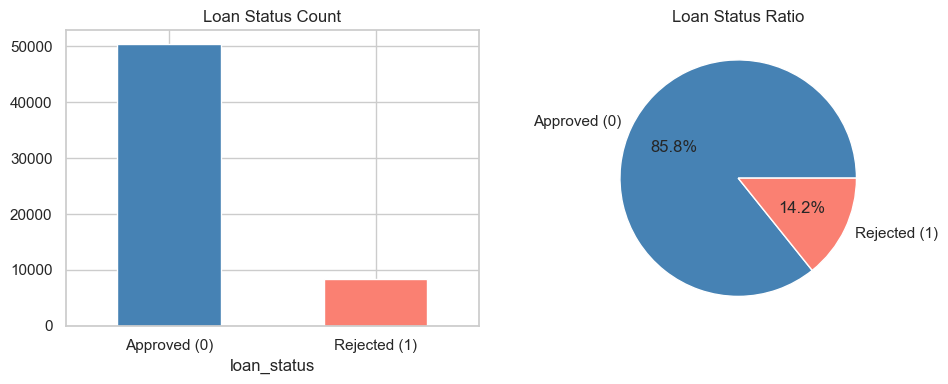

In [6]:
target_counts = train['loan_status'].value_counts()
target_pct    = train['loan_status'].value_counts(normalize=True) * 100
print(pd.DataFrame({'count': target_counts, 'pct': target_pct.round(2)}))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
target_counts.plot(kind='bar', ax=axes[0], color=['steelblue', 'salmon'])
axes[0].set_title('Loan Status Count')
axes[0].set_xticklabels(['Approved (0)', 'Rejected (1)'], rotation=0)
axes[1].pie(target_counts, labels=['Approved (0)', 'Rejected (1)'],
            autopct='%1.1f%%', colors=['steelblue', 'salmon'])
axes[1].set_title('Loan Status Ratio')
plt.tight_layout()
plt.show()

### Observations
- **85.8% approved (0)** vs **14.2% defaulted (1)** — the dataset is moderately imbalanced (~6:1 ratio)
- This imbalance means accuracy is a misleading metric; AUC-ROC (used by this competition) is appropriate
- Consider using `class_weight='balanced'` or scale_pos_weight in tree models to handle imbalance

## Feature Descriptions

| Column | Type | Description |
|---|---|---|
| `id` | int | Unique identifier for each loan application |
| `person_age` | int | Age of the applicant in years |
| `person_income` | int | Annual income of the applicant (USD) |
| `person_home_ownership` | str | Applicant's home ownership status — `RENT`, `OWN`, `MORTGAGE`, `OTHER` |
| `person_emp_length` | float | Length of employment in years |
| `loan_intent` | str | Purpose of the loan — `EDUCATION`, `MEDICAL`, `VENTURE`, `PERSONAL`, `HOMEIMPROVEMENT`, `DEBTCONSOLIDATION` |
| `loan_grade` | str | Credit grade assigned to the loan — `A` (best) through `G` (worst), reflecting credit risk |
| `loan_amnt` | int | Requested loan amount (USD) |
| `loan_int_rate` | float | Interest rate on the loan (%) |
| `loan_percent_income` | float | Ratio of loan amount to annual income (`loan_amnt / person_income`) |
| `cb_person_default_on_file` | str | Whether the applicant has a historical default on record — `Y` (yes) or `N` (no) |
| `cb_person_cred_hist_length` | int | Length of the applicant's credit history in years |
| `loan_status` | int | **Target** — `0` = loan approved, `1` = loan defaulted/rejected |

## 4. Numerical Features Distribution

Numerical features: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


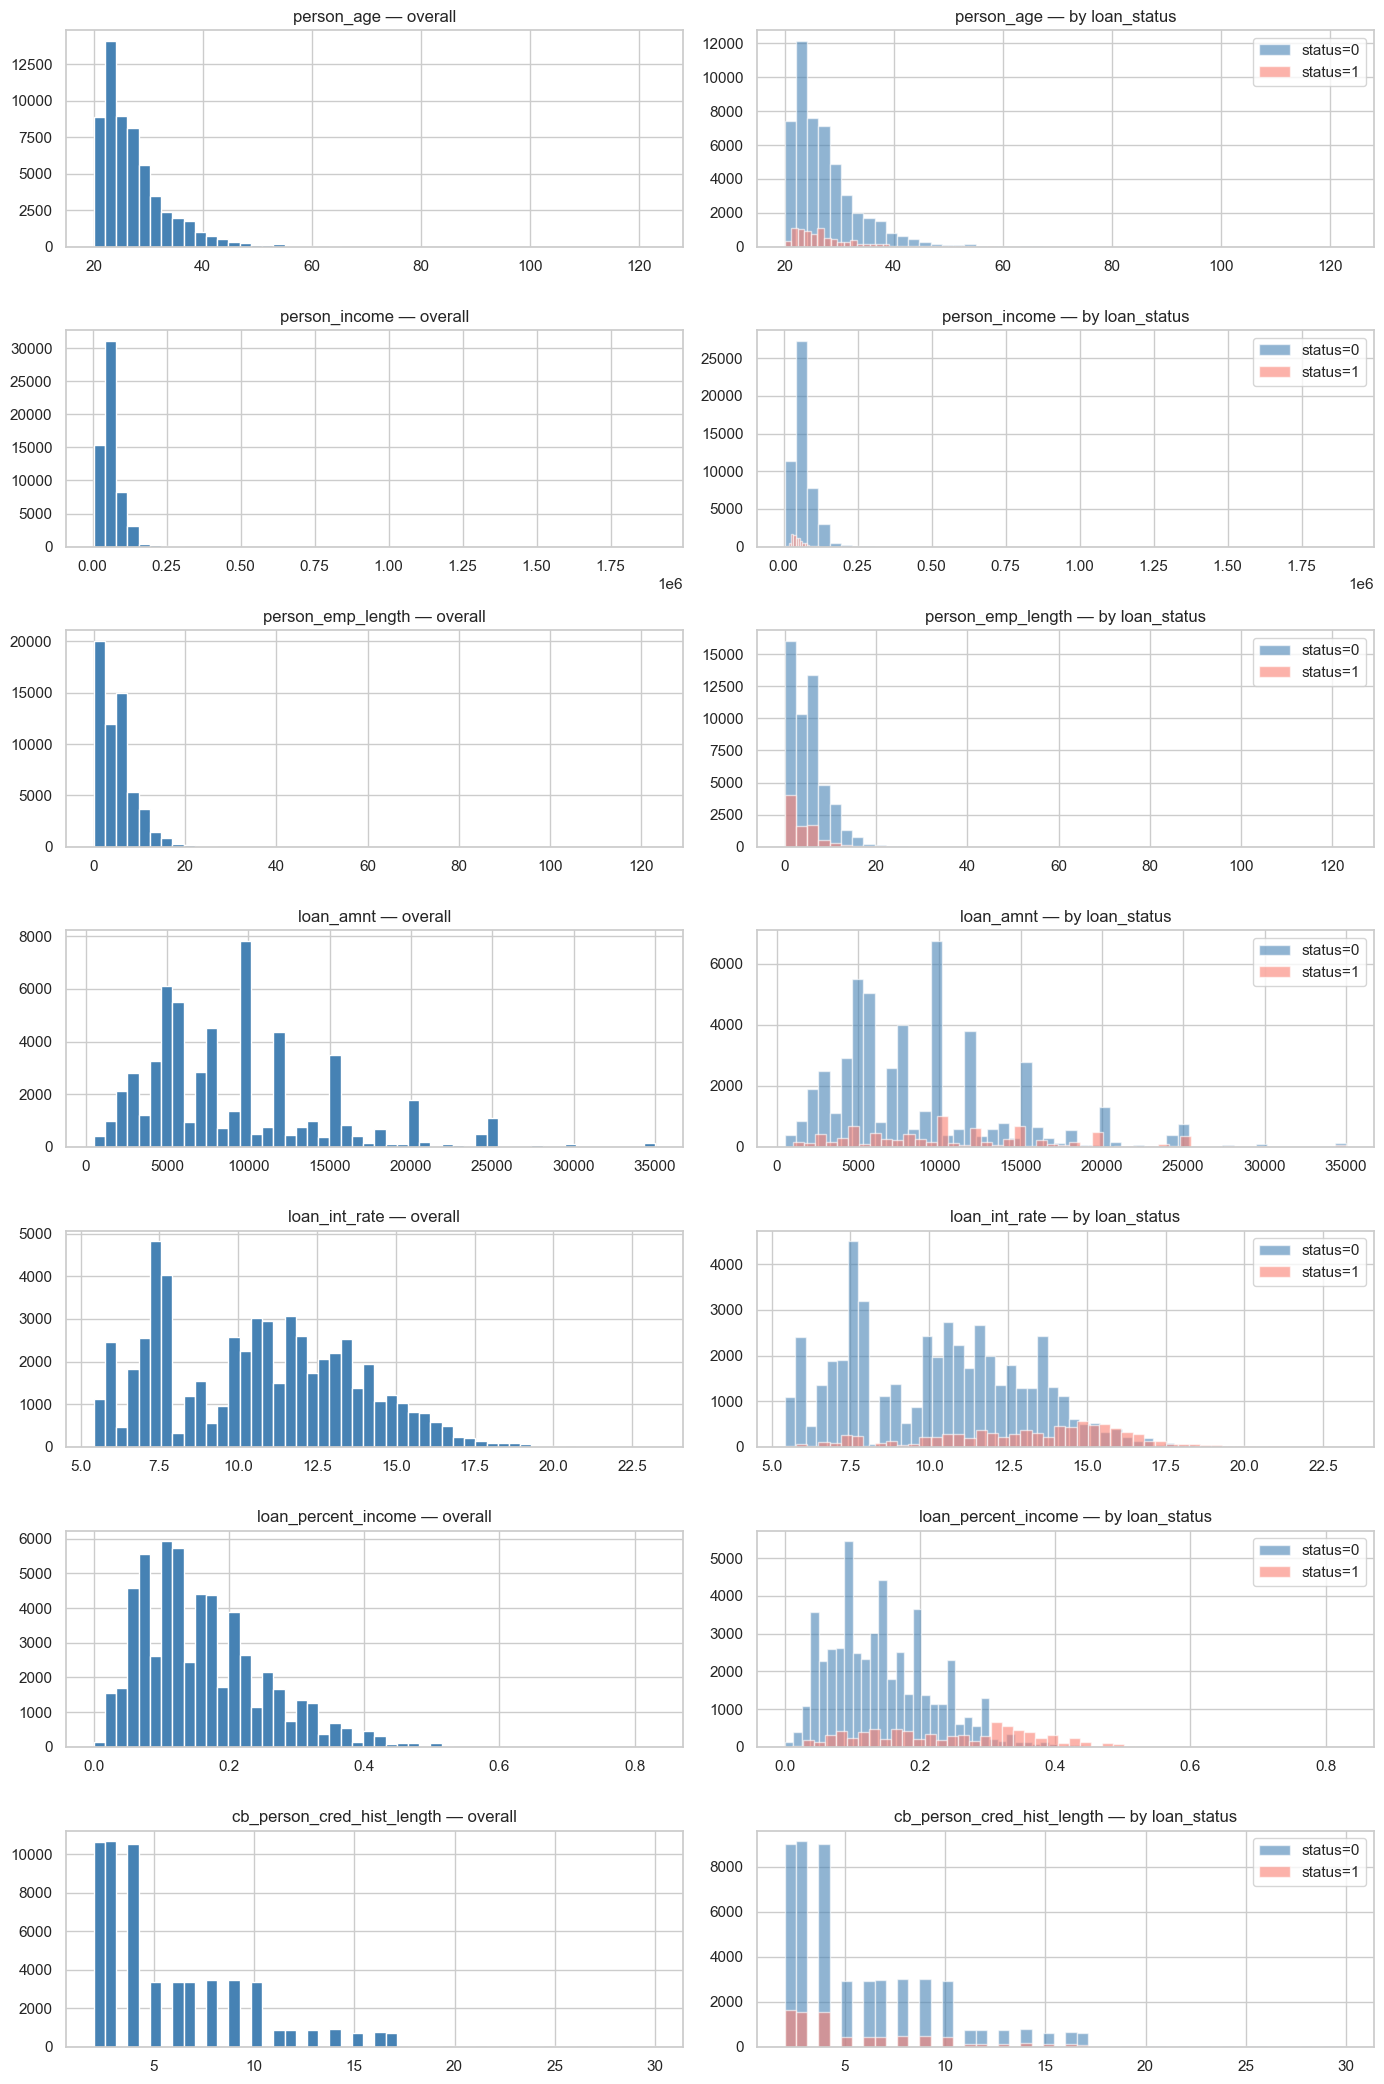

In [7]:
num_cols = train.select_dtypes(include='number').columns.drop(['id', 'loan_status']).tolist()
print('Numerical features:', num_cols)

fig, axes = plt.subplots(len(num_cols), 2, figsize=(14, len(num_cols) * 3))
for i, col in enumerate(num_cols):
    axes[i, 0].hist(train[col].dropna(), bins=50, color='steelblue', edgecolor='white')
    axes[i, 0].set_title(f'{col} — overall')
    for status, color in zip([0, 1], ['steelblue', 'salmon']):
        axes[i, 1].hist(train.loc[train['loan_status'] == status, col].dropna(),
                        bins=50, alpha=0.6, color=color, label=f'status={status}', edgecolor='white')
    axes[i, 1].set_title(f'{col} — by loan_status')
    axes[i, 1].legend()
plt.tight_layout()
plt.show()

### Observations
- **`loan_percent_income`** (corr=0.378) and **`loan_int_rate`** (corr=0.339) are the strongest numerical predictors of default — defaulters have median 0.25 vs 0.13 and 13.79% vs 10.39% respectively
- **`person_income`** (corr=-0.170) is negatively correlated: defaulters have median income $44K vs $60K for approvals
- **`loan_amnt`** (corr=0.145): defaulters request larger loans (median $10K vs $8K)
- **`person_age`** and **`cb_person_cred_hist_length`** have near-zero correlation with target — low individual predictive power
- **Outlier alert**: `person_age` (max=123, 99th pct=49) and `person_emp_length` (max=123, 99th pct=17) contain extreme values that should be capped

## 5. Categorical Features Distribution

Categorical features: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


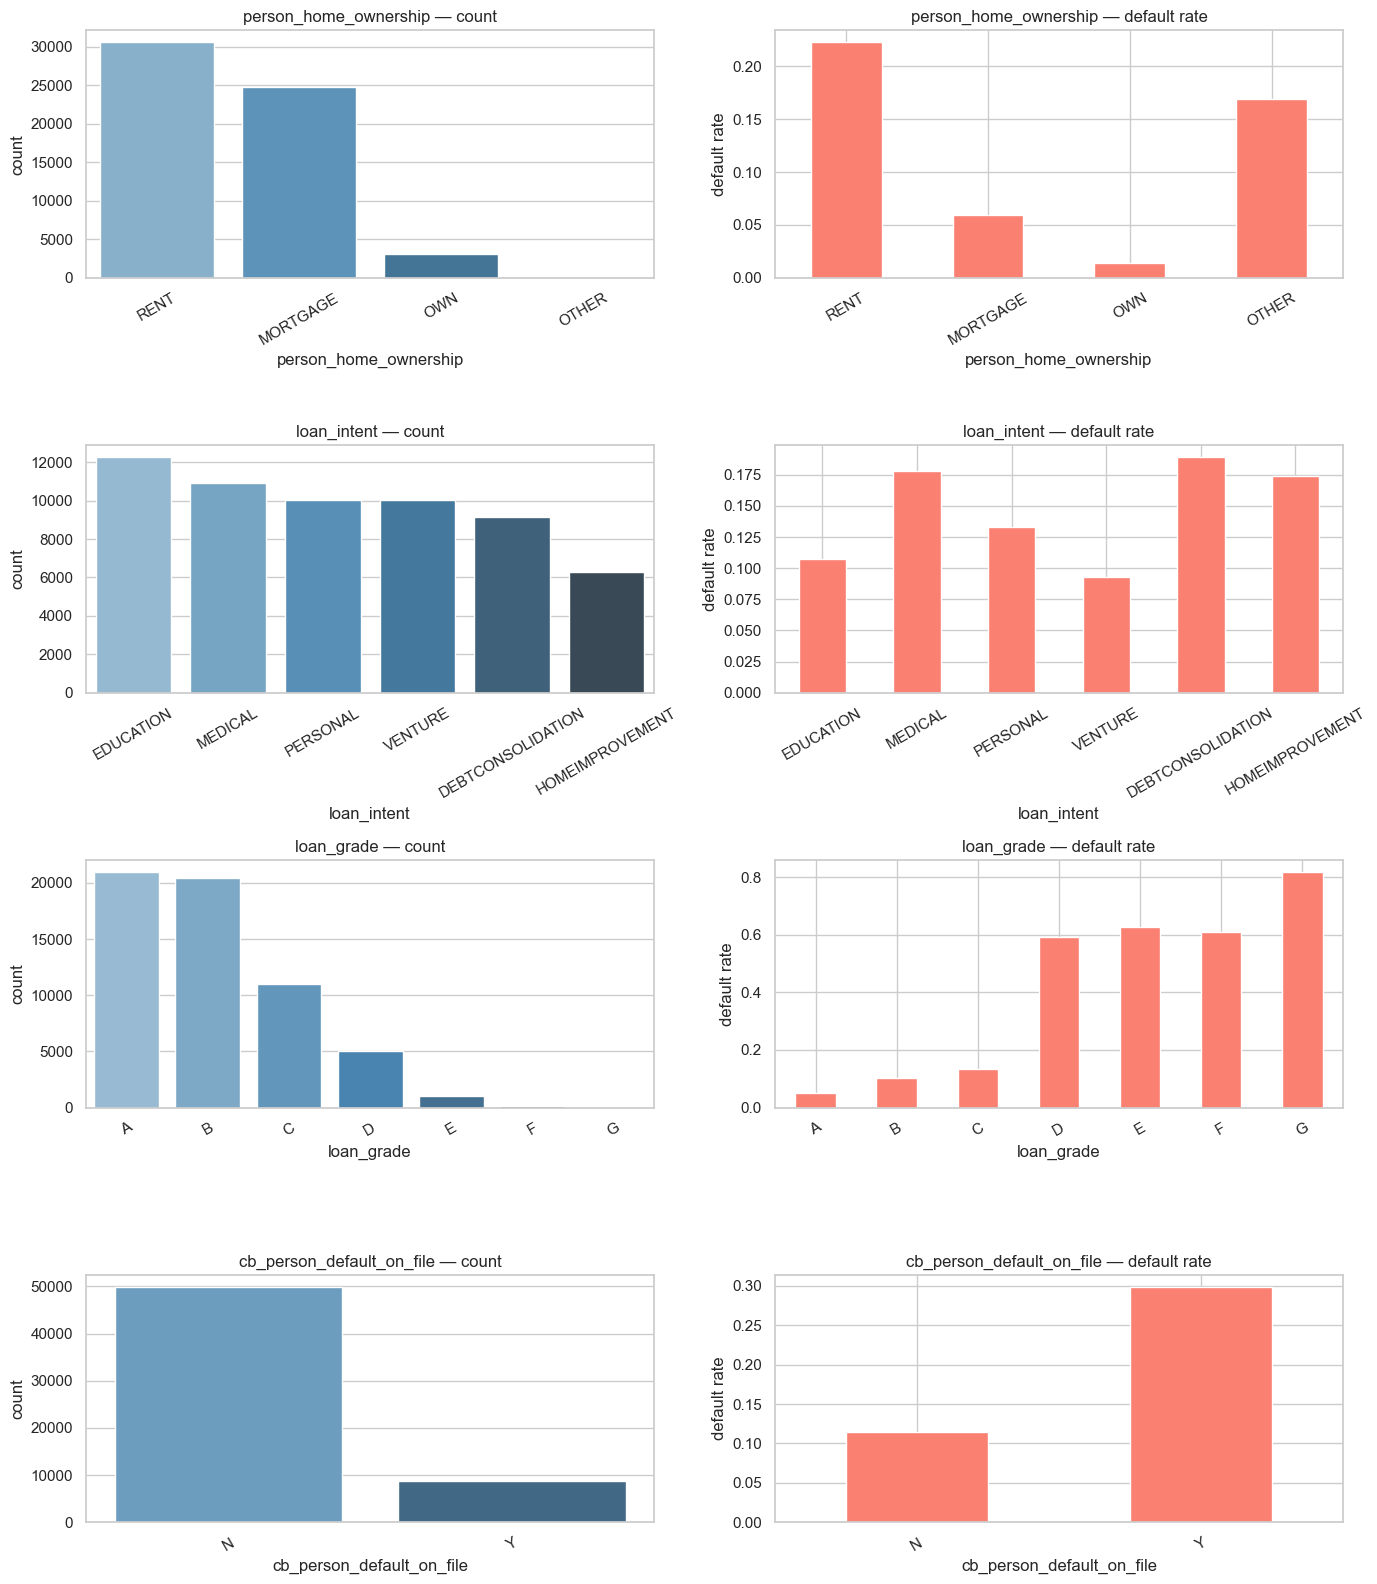

In [8]:
cat_cols = train.select_dtypes(include='object').columns.tolist()
print('Categorical features:', cat_cols)

fig, axes = plt.subplots(len(cat_cols), 2, figsize=(14, len(cat_cols) * 4))
for i, col in enumerate(cat_cols):
    order = train[col].value_counts().index
    sns.countplot(data=train, x=col, order=order, ax=axes[i, 0], palette='Blues_d')
    axes[i, 0].set_title(f'{col} — count')
    axes[i, 0].tick_params(axis='x', rotation=30)
    default_rate = train.groupby(col)['loan_status'].mean().reindex(order)
    default_rate.plot(kind='bar', ax=axes[i, 1], color='salmon')
    axes[i, 1].set_title(f'{col} — default rate')
    axes[i, 1].set_ylabel('default rate')
    axes[i, 1].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

### Observations
- **`loan_grade`** is the most powerful categorical predictor: default rate jumps from 4.9% (A) → 81.8% (G). Grades D–G carry extreme risk. This feature alone provides near-perfect class separation at the extremes
- **`person_home_ownership`**: RENT (22.3%) and OTHER (16.9%) show significantly higher default rates than MORTGAGE (6.0%) and OWN (1.4%) — home ownership is a strong proxy for financial stability
- **`cb_person_default_on_file`**: applicants with a prior default (Y) default at 29.9% vs 11.5% for those without — historical behaviour is predictive
- **`loan_intent`**: DEBTCONSOLIDATION (18.9%) and MEDICAL (17.8%) loans default most, while VENTURE (9.3%) and EDUCATION (10.8%) are lower risk

## 6. Correlation Heatmap

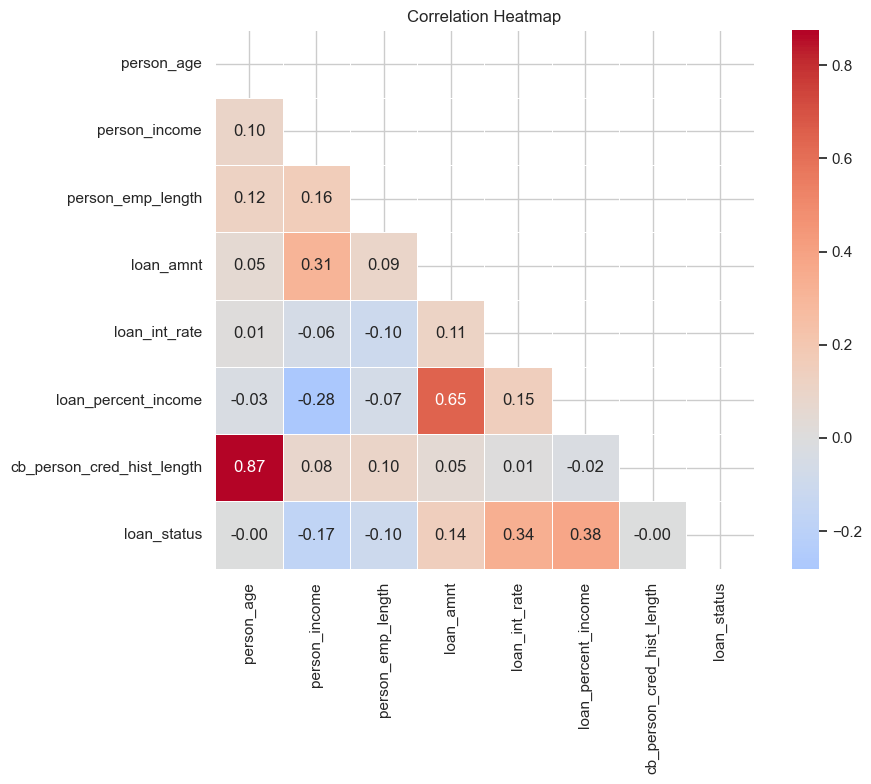

In [9]:
corr = train[num_cols + ['loan_status']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

### Observations
- **`loan_percent_income`** (0.378) and **`loan_int_rate`** (0.339) are the most correlated numerical features with `loan_status`
- **`person_income`** (-0.170) and **`person_emp_length`** (-0.100) are negatively correlated — higher income/employment stability reduces default risk
- `loan_int_rate` and `loan_percent_income` are moderately correlated with each other — both capture loan burden, so feature interaction between them may be redundant
- `person_age` and `cb_person_cred_hist_length` are strongly correlated (~0.8) — longer credit history naturally comes with age; consider dropping one or combining them

## 7. Outlier Check (Boxplots)

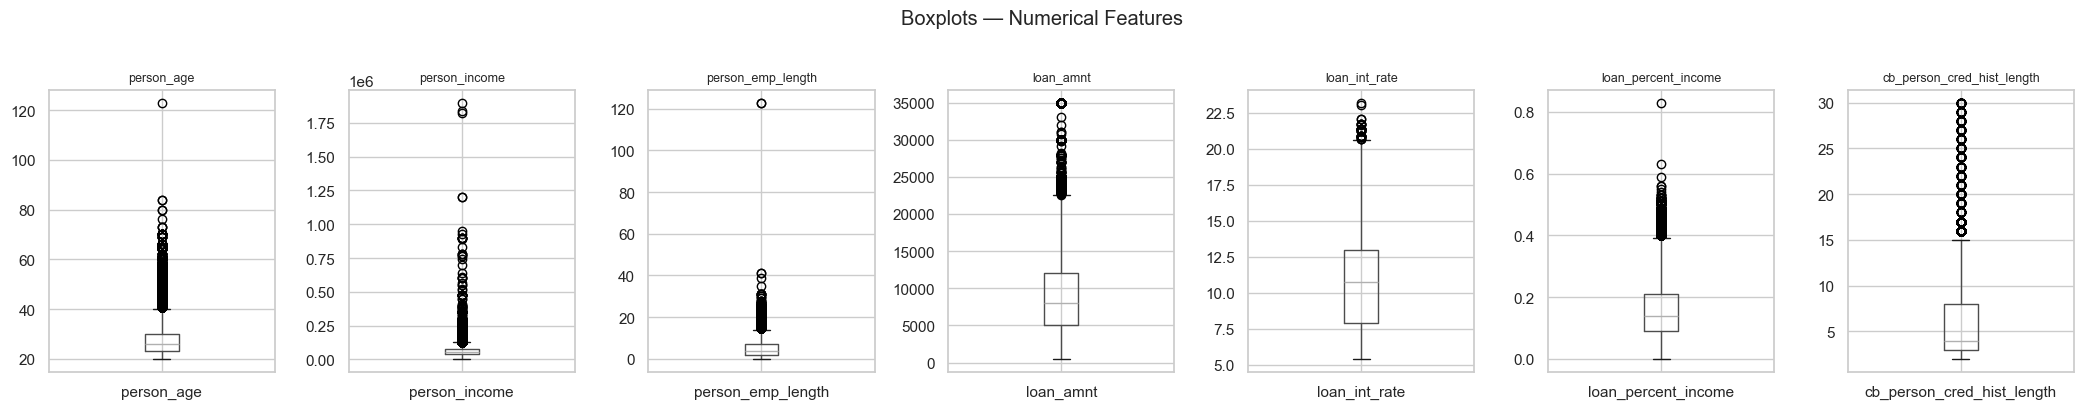

In [10]:
fig, axes = plt.subplots(1, len(num_cols), figsize=(3 * len(num_cols), 4))
for i, col in enumerate(num_cols):
    train.boxplot(column=col, ax=axes[i])
    axes[i].set_title(col, fontsize=9)
plt.suptitle('Boxplots — Numerical Features', y=1.02)
plt.tight_layout()
plt.show()

### Observations
- **`person_age`**: extreme outliers above ~60 (max=123) — cap at 99th percentile (~49)
- **`person_emp_length`**: extreme outliers above ~30 (max=123) — cap at 99th percentile (~17)
- **`person_income`**: strong right skew with high-value outliers ($1.9M) — consider log transform or capping
- **`loan_amnt`** and **`loan_int_rate`**: mild right skew, no extreme outliers worth capping
- **`loan_percent_income`**: a few values near 0.8+ but mostly well-bounded; reflects the income outliers upstream

## 8. Median Stats by Target

In [11]:
train.groupby('loan_status')[num_cols].median().T

loan_status,0,1
person_age,26.00,26.00
person_income,60000.00,44000.00
person_emp_length,4.00,3.00
loan_amnt,8000.00,10000.00
loan_int_rate,10.39,13.79
loan_percent_income,0.13,0.25
cb_person_cred_hist_length,4.00,4.00


### Observations
- **Income gap**: defaulters earn $16K less at median ($44K vs $60K) — a 27% income deficit
- **Interest rate gap**: defaulters pay 3.4pp more (13.79% vs 10.39%) — likely reflects their lower credit grades
- **Loan burden**: defaulters borrow more ($10K vs $8K) relative to lower income, pushing `loan_percent_income` from 0.13 → 0.25 (nearly 2×)
- **`person_age`** and **`cb_person_cred_hist_length`** are identical between groups — not individually discriminating on their own
- **Key takeaway**: the strongest signal is the combination of high loan burden (`loan_percent_income`) and high interest rate (`loan_int_rate`), both symptoms of weaker credit quality captured in `loan_grade`

## 9. Train vs Test Distribution

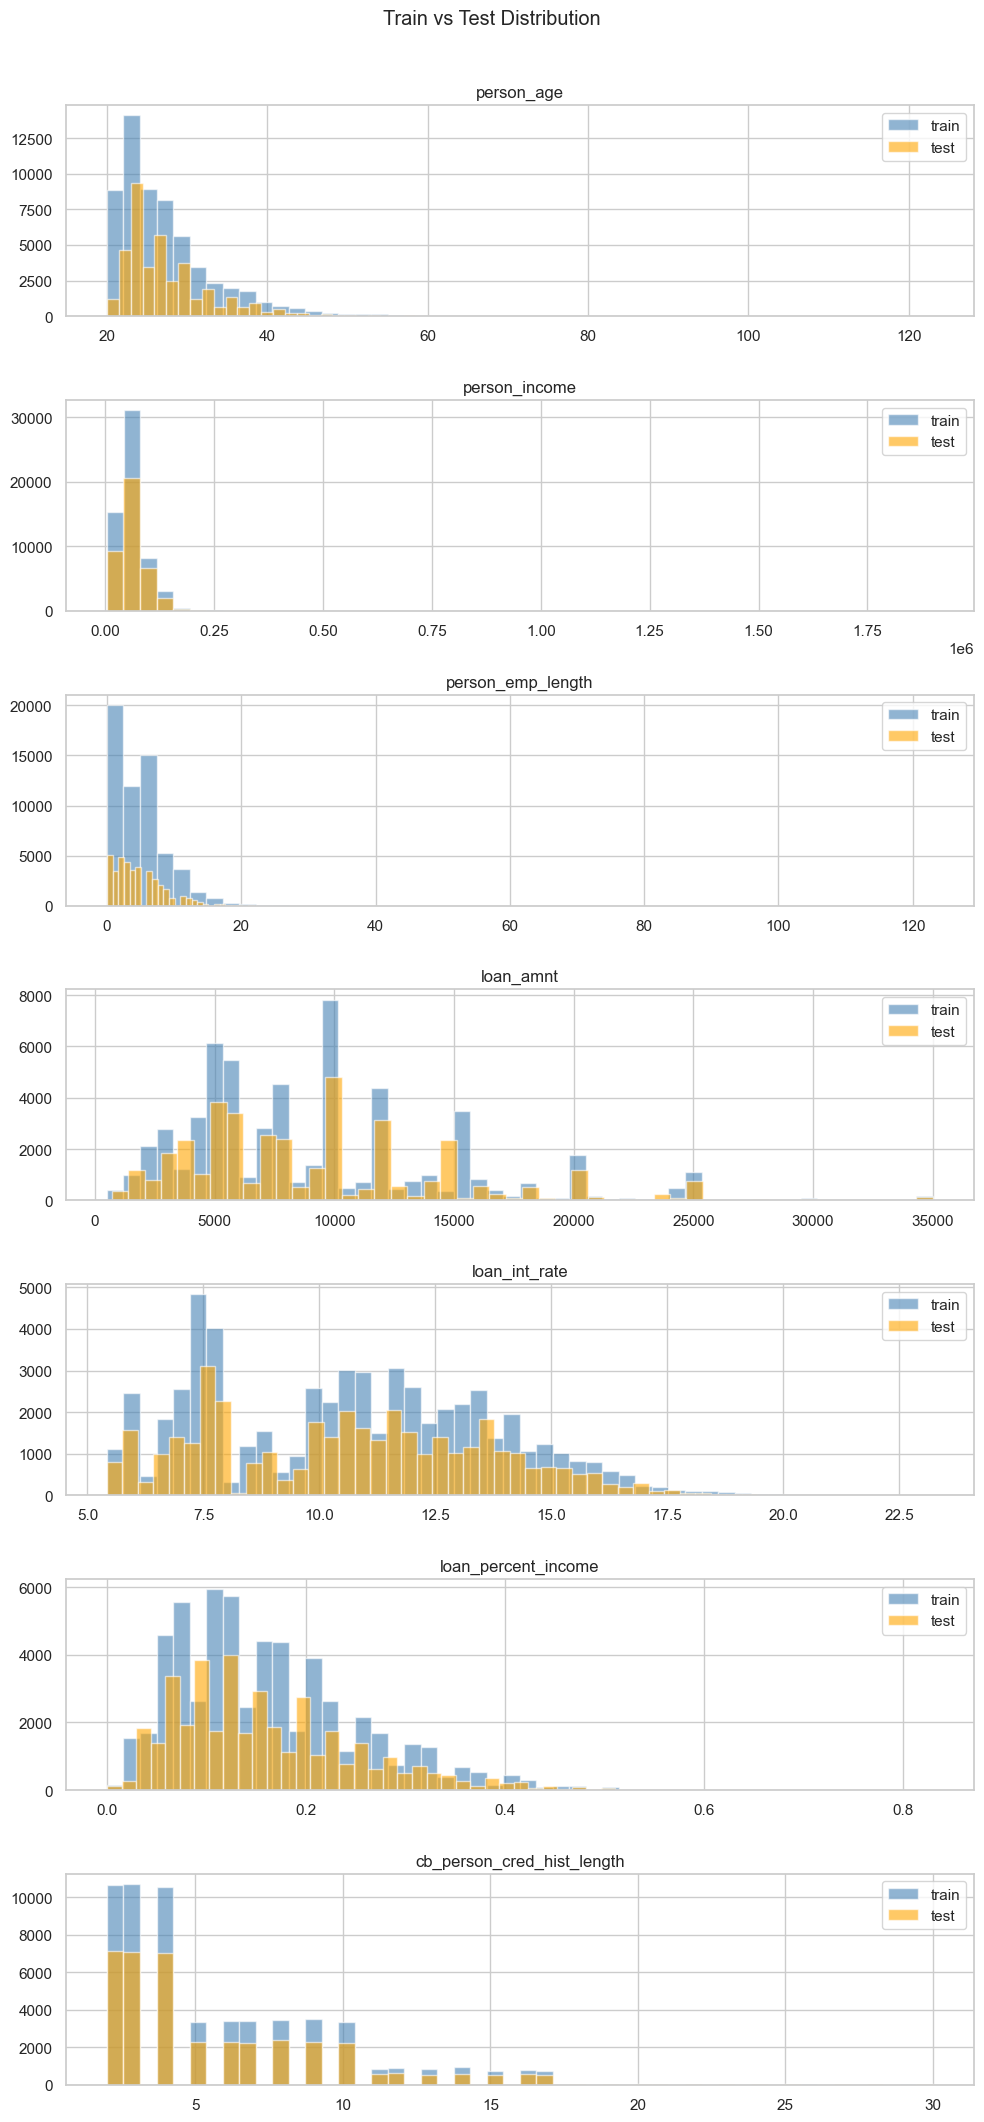

In [12]:
fig, axes = plt.subplots(len(num_cols), 1, figsize=(10, len(num_cols) * 3))
for i, col in enumerate(num_cols):
    axes[i].hist(train[col].dropna(), bins=50, alpha=0.6, label='train', color='steelblue')
    axes[i].hist(test[col].dropna(),  bins=50, alpha=0.6, label='test',  color='orange')
    axes[i].set_title(col)
    axes[i].legend()
plt.suptitle('Train vs Test Distribution', y=1.01)
plt.tight_layout()
plt.show()

### Observations
- Train and test distributions are closely aligned across all numerical features — no major distribution shift, suggesting the test set was generated from the same underlying process
- `person_income` and `loan_amnt` show near-identical skew profiles in both sets
- `person_age` and `person_emp_length` outliers (123) appear in both train and test — confirm these are a dataset-wide artefact, not train-specific noise
- No significant covariate shift detected — standard cross-validation should be a reliable proxy for test performance